In [1]:
# 📦 Pakete
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel


In [2]:
# 📄 Excel-Datei mit 28 Items laden
df = pd.read_excel("UX-Daten.xlsx", sheet_name="Formularantworten 1")
df.head()


,Zeitstempel,Einverständnis,Wie alt bist du?,Mit welchem Geschlecht identifizierst du dich?,Hast du bereits Erfahrung mit Augmented Reality gemacht?,Wie oft kaufst du online ein?,AR technisch - menschlich (PQ),AR kompliziert - einfach (PQ),AR unpraktisch - praktisch (PQ),AR umständlich - direkt (PQ),...,Bild hässlich - schön (ATT),Bild unsympathisch - sympathisch (ATT),Bild zurückweisend - einladend (ATT),Bild schlecht - gut (ATT),Bild abstossend - anziehend (ATT),Bild entmutigend – motivierend (ATT),Welche der beiden Darstellungen hat dir besser gefallen? Warum?,Welche Darstellung war für dich intuitiver zu bedienen?,"Bei welcher Darstellung hattest du mehr das Gefühl, das Produkt real zu erleben?",Welche Darstellung würde dich eher zum Kauf eines Produkts bewegen? Warum?
0,NaN,NaN,26,Weiblich,Ja,Gelegentlich,3,6,6,6,...,5,4,5,5,4,4,AR - Besser vorstellbar und interaktiv einladend,AR - wolle bei Bild zoomen,AR,tendenziell AR wenn ich das so im Vergleich se...
1,NaN,NaN,24,Männlich,Nein,Gelegentlich,4,6,6,6,...,3,4,4,4,4,4,AR fand ich sehr innovativ.,"AR lief sehr flüssig, Bild war hochwertig.",AR fühl sich an als ob es im Raum ist.,Beide Zusammen wären eine gute Kombo.
2,NaN,NaN,56,Weiblich,Ja,Gelegentlich,3,6,6,6,...,5,6,6,5,5,5,"AR , visuell gut vorstellbar",AR bild war allerdings hochwertig.,AR das es sich anfühlte als wäre es im Raum,"AR, die Visualiesierung mit dem Raum."
3,NaN,NaN,62,Männlich,Nein,Selten,2,3,7,3,...,6,6,7,5,6,6,Visuelle. Darstellung im eigenen Umfeld,Bildliche,Visuelle,Visuelle
4,NaN,NaN,22,Weiblich,Nein,Oft,3,7,5,7,...,5,5,4,5,6,4,AR war für mich aufregend und hat mehr freude/...,Die Version mit den Bilder war einfach zu bedi...,Ganz klar bei der AR. Das Produkt konnt direkt...,"Ich denke die AR Version, wenn es um ein Möbel..."


In [3]:
# 🧾 Teilnehmer-ID hinzufügen
df.insert(0, "TeilnehmerID", range(1, len(df) + 1))


In [4]:
# 🎯 Relevante Bewertungsspalten finden
value_cols = [col for col in df.columns if col.startswith("AR ") or col.startswith("Bild ")]

In [5]:
# 🔄 Long-Format erzeugen
df_long = df.melt(
    id_vars=["TeilnehmerID"],
    value_vars=value_cols,
    var_name="ItemBedingung",
    value_name="Wert"
)

# 🧠 Bedingung (AR / Bild) extrahieren
df_long["Bedingung"] = df_long["ItemBedingung"].apply(lambda x: "AR" if x.startswith("AR ") else "Bild")

# ✂ Item-Namen bereinigen
df_long["Item"] = df_long["ItemBedingung"].str.replace(r"^(AR |Bild )", "", regex=True)

# 📚 UX-Dimension aus Item-Namen extrahieren (z. B. "(PQ)")
df_long["Dimension"] = df_long["Item"].str.extract(r"\((.*?)\)$")[0]

# 📊 Mittelwert je Teilnehmer x Dimension x Bedingung berechnen
df_mean = df_long.groupby(["TeilnehmerID", "Dimension", "Bedingung"])["Wert"].mean().reset_index()


In [6]:
# 🔁 Pivot für t-Test
pivot = df_mean.pivot(index=["TeilnehmerID", "Dimension"], columns="Bedingung", values="Wert").dropna()

In [7]:
# 🧪 T-Test + Effektstärke (Cohen’s d) pro Dimension
results = []
for dim in pivot.index.get_level_values("Dimension").unique():
    ar = pivot.xs(dim, level="Dimension")["AR"]
    bild = pivot.xs(dim, level="Dimension")["Bild"]
    t, p = ttest_rel(ar, bild)
    d = (ar.mean() - bild.mean()) / np.sqrt(((ar.std(ddof=1)**2 + bild.std(ddof=1)**2)/2))
    results.append({
        "Dimension": dim,
        "Mittelwert_AR": ar.mean(),
        "Mittelwert_Bild": bild.mean(),
        "t-Wert": t,
        "p-Wert": p,
        "Cohen's d": d
    })

In [8]:
# 📄 Ergebnis als DataFrame anzeigen
df_results = pd.DataFrame(results)
df_results.sort_values("p-Wert")  # optional: sortiert nach Signifikanz anzeigen

,Dimension,Mittelwert_AR,Mittelwert_Bild,t-Wert,p-Wert,Cohen's d
2,HQ-S,5.224762,3.125714,6.045940,0.000003,1.672682
1,HQ-I,5.082857,4.491429,2.517380,0.018907,0.695864
3,PQ,4.980000,5.504762,-1.853859,0.076091,-0.484944
0,ATT,5.497143,5.182857,1.374106,0.182107,0.374634


In [9]:
df_results.to_excel("auswertung_UXdimensionen.xlsx", index=False)


Matplotlib is building the font cache; this may take a moment.


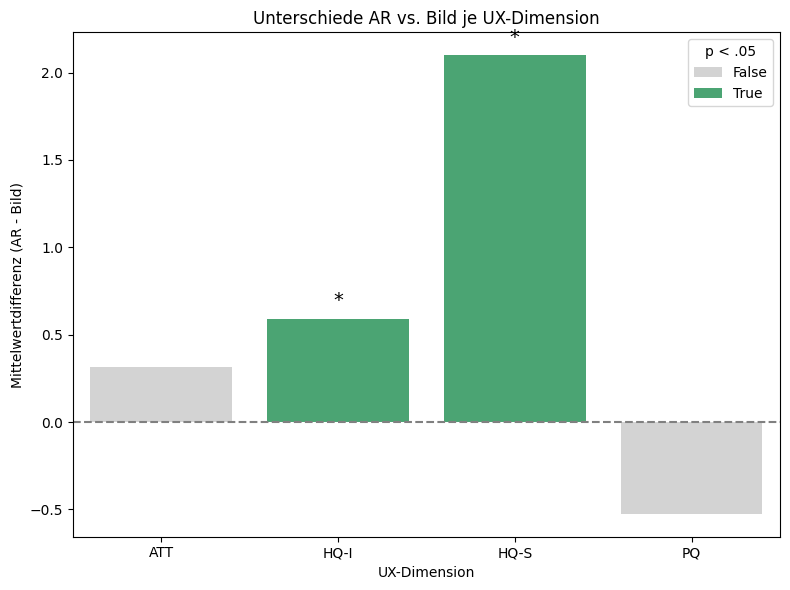

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Balkendiagramm vorbereiten
plt.figure(figsize=(8, 6))

# Daten für Plot vorbereiten
plot_data = df_results.copy()
plot_data["Differenz"] = plot_data["Mittelwert_AR"] - plot_data["Mittelwert_Bild"]
plot_data["Signifikant"] = plot_data["p-Wert"] < 0.05

# Balkenplot
sns.barplot(
    data=plot_data,
    x="Dimension",
    y="Differenz",
    hue="Signifikant",
    palette={True: "mediumseagreen", False: "lightgray"},
    dodge=False
)

# ⭐ Signifikanz-Sternchen manuell hinzufügen
for index, row in plot_data.iterrows():
    y = row["Differenz"]
    sig = row["Signifikant"]
    if sig:
        plt.text(index, y + 0.05, "*", ha='center', va='bottom', fontsize=14, color="black")

# Labels und Titel
plt.axhline(0, color='gray', linestyle='--')
plt.title("Unterschiede AR vs. Bild je UX-Dimension")
plt.ylabel("Mittelwertdifferenz (AR - Bild)")
plt.xlabel("UX-Dimension")
plt.legend(title="p < .05")
plt.tight_layout()
plt.show()
